In [1]:
import copy
import math
import random
import socket
import time
from collections import deque, namedtuple
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Normal

In [13]:
device = torch.device('cpu')
lr = 7e-4
weight_decay = 1e-2
clip_param = 0.2
gamma = 0.98
batch_size = 256
train_step_m = 4
%config InlineBackend.figure_format='svg'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
torch.set_default_device(device)

In [14]:
class TrainBuffer:
    def __init__(self, size):
        self.i_list = []
        self.o_list = []
        self.act_list = []
        self.r_list = []
        self.done_list = []
        self.dis_reward=[]

        self.size = size
        self.mse = torch.nn.MSELoss()

    def clear(self):
        self.i_list.clear()
        self.o_list.clear()
        self.act_list.clear()
        self.r_list.clear()
        self.done_list.clear()
    
    def full(self):
        return len(self.i_list) >= self.size

    def add(self, i, o, act, r, done):
        self.i_list.append(i.detach())
        self.o_list.append(o.detach())
        self.act_list.append([act])
        self.r_list.append(r)
        self.done_list.append(done)

    def train(self, actor, critic, opt_a, opt_c, mse_his):
        rewards = []
        with torch.no_grad():
            dis_reward = float(critic(self.i_list[-1]))
        for r, done in zip(reversed(self.r_list), reversed(self.done_list)):
            if done:
                dis_reward = 0.0
            dis_reward = r + gamma * dis_reward
            rewards.append([dis_reward])
        self.dis_reward.append([dis_reward])
        rewards = torch.tensor(list(reversed(rewards)), device=device)
        i = torch.stack(self.i_list)
        act = torch.tensor(self.act_list, device=device, requires_grad=False)
        


        pa_old = torch.tensor([[prob[action]] for prob, action in zip(self.o_list, self.act_list)], device=device)
        for t in range(train_step_m):
            prob_new = actor.forward(i)
            r = prob_new.gather(1, act) / pa_old
            a_ = None
            with torch.no_grad():
                a_ = rewards - critic(i)

            l_clip = -torch.min(r * a_, torch.clamp(r, 1 - clip_param, 1 + clip_param) * a_)
            opt_a.zero_grad()
            l_clip.mean().backward()
            opt_a.step()

            l_bl = self.mse(rewards, critic(i))
            #$l_bl = l_bl.float()
            if t == 0:
                mse_his.append(float(l_bl))
            opt_c.zero_grad()
            l_bl.mean().backward()
            opt_c.step()


In [15]:
def get_critic():
    return nn.Sequential(
        nn.Linear(8, 32, device=device),
        nn.Tanh(),
        nn.Linear(32, 32, device=device),
        nn.Tanh(),
        nn.Linear(32, 1, device=device)        
    )

In [16]:
def get_agent():
    return nn.Sequential(
        nn.Linear(8, 32, device=device),
        nn.Tanh(),
        nn.Linear(32, 32, device=device),
        nn.Tanh(),
        nn.Linear(32, 15, device=device),   
        nn.Softmax(dim=-1)
    )

In [ ]:
class Agent:
    def __init__(self, port: int):
        self.input = {}
        self.output = {}
        self.round = 0
        self.last_range = 0 #高超特有
        self.into_danger = 0

        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.bind(("localhost", port))
        s.listen()
        self.link, _ = s.accept()

        self.agent = get_agent()
        self.opt = optim.AdamW(self.agent.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
        self.critic = get_critic()
        self.opt_critic = optim.AdamW(self.critic.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)

        self.his = []        
        self.final_reward = []
        self.critic_mse = []
        self.train_data = TrainBuffer(batch_size)
        self.traj_list=[] #高超特有

        self.reward_pre = 0
        self.output_v = None

        self.end = False        
        self.able2draw=False
        self.sucess=False
        self.clear_state()
        self.recv_input()

    def cal_reward(self):
        a1 = 4
        a2 = 4
        a3 = 2
        a4 = 30
        a5 = 100
        r_danger=0.0
        r_dis= 0
        r_angledanger=0
        r_gravity=0
    
        
        if self.input['output_altitude'] < 25000.0 or self.input['output_longitude'] > 150.0 or self.input['output_latitude']<20.0:                    
            self.end=True
            if self.into_danger==1:
                if self.input['output_range'] < 7000.0:
                    self.final_reward.append(-1)
                    reward=-a5
                else:
                    self.final_reward.append(-2)
                    reward = np.clip(-self.input['output_range']/160.0,-50,0)
                    reward=float(reward)-a5   

                
            else:
                if self.input['output_range'] < 7000.0:
                    reward = a5
                    self.final_reward.append(1)
                    self.able2draw=True
                    self.sucess=True
                    # column=['经度','维度','高度']                
                    # test=pd.DataFrame(columns=column,data=self.traj_list)#将数据放进表格
                    # test.to_csv('test.csv') #数据存入csv,存储位置及文件名称
                else:
                    #reward = np.array(reward)
                    reward = np.clip(-self.input['output_range']/160.0,-50,0)
                    reward=float(reward)                
                    self.final_reward.append(0)
        
             
            
            
            
        else:
            if self.input['r_glide_forbid']<self.input['r_forbid']*1.1:
                r_danger = -a2
                self.into_danger=1

           
            if self.input['output_range']<self.last_range:
                r_dis= a3            

            # r_gravity=-self.input['output_range']/(20*5400000.0)
            #r_gravity=0

            
            # if self.input['r_glide_forbid']<4.0*self.input['r_forbid']:
            #     if abs(self.input["theta1"]) < abs(self.input["theta0"]):
            #         r_angledanger = a4 * (abs(self.input["theta1"]) - abs(self.input["theta0"]))
            #     # elif abs(self.input["theta1"]) - abs(self.input["theta0"])<20.0/ 180.0 * np.pi:
            #     #     r_angledanger = a1 * (abs(self.input["theta1"]) - abs(self.input["theta0"]))
            r_angledanger=-a4*abs(self.input['Ideal_AngleSideslipe']- self.output["AngleSideslipe"])     
            reward = r_angledanger +r_dis+r_gravity+r_danger
        self.last_range=self.input['output_range']
      
            
        return reward

    def clear_state(self):
        self.reward_pre = 0        
        self.input.clear()
        self.output.clear()
        self.last_range=0
        self.reward_pre = 0
        self.output_v = None
        self.traj_list.clear()        
        self.able2draw=False
        self.into_danger=0
        self.output["AngleSideslipe"] = 0

    def send_output(self):
        if self.end:
            # if self.able2draw:
            #     column=['经度','维度','高度']
            #     #column=['高度']  
            #     test=pd.DataFrame(columns=column,data=self.traj_list)#将数据放进表格
            #     test.to_csv('test.csv') #数据存入csv,存储位置及文件名称
            self.send('<c><restart><uint32_t>1</uint32_t></restart></c>')
            self.clear_state()
            self.round += 1
            return
        
        AngleSideslipe_dir = f'<AngleSideslipe><double>{self.output["AngleSideslipe"]}</double></AngleSideslipe>'
        s = '<c>' +  AngleSideslipe_dir + '</c>'
        self.send(s)

    def recv_input(self):
        s = self.recv()
        try:
            self.input = eval(s)[0]
            #self.traj_list.append([self.input['output_longitude'],self.input['output_latitude'],self.input['output_altitude']])
            if 'output_altitude' in self.input and self.input['output_altitude'] is not None:
                self.traj_list.append([self.input['output_longitude'],self.input['output_latitude'],self.input['output_altitude']])
            
            
        except:
            print(s) 
            raise ValueError
        #self.end = ("is_danger" in self.input and self.input["is_danger"] == 1) 

    def send(self, s: str):
        self.link.send(s.encode() + b'\n')

    def recv(self)->str:
        """will return string ends with '\\n'"""
        s: bytes = b''
        while not s.endswith(b'\n'):
            s = s + self.link.recv(1024)
        # if log:
        #     print(f'received: {s.decode()}')
        return s.decode()

    def tick(self):
        # TODO:
        #print("input_v:", self.input) 

        input_v = [
            self.input['output_altitude']/70000,
            self.input['r_forbid'] / 300000,
            self.input['r_glide_forbid'] / 1800000,
            self.input['theta0'] / np.pi * 2,
            self.input['theta1'] / np.pi,
            self.input['output_range'] / 5400000,
            self.input['output_speed'] / 6500,
            self.input['Ideal_AngleSideslipe']/ np.pi,            
        ]
        self.input_v = torch.tensor(input_v)
        with torch.no_grad():
            self.output_v = self.agent(self.input_v)       
        m = torch.distributions.Categorical(self.output_v)
        action = m.sample().item()
        self.act=action
        #print("output_v:", self.output_v)
        #print("action_probs:", action_probs)   
        #print("action:", action)        


        self.output["AngleSideslipe"] = -70.0 /180.0 *np.pi + action * 10.0 /180.0 * np.pi
        #print("self.output:", self.output["AngleSideslipe"]) 
 
    def train_step(self):
        if self.output_v is None:
            return
        r = self.cal_reward()
        self.his.append(r)
        self.train_data.add(self.input_v, self.output_v, self.act, r, self.end)
        if self.train_data.full():
            self.train_data.train(self.agent, self.critic, self.opt, self.opt_critic, self.critic_mse)
            self.train_data.clear()
        # loss = -r * torch.log(o[act])
        # self.opt.zero_grad()
        # loss.backward()
        # self.opt.step()

In [18]:
def train(a: Agent, total_iters, enable_log=True,train_flag=True,load_flag=True):
    if load_flag:
        a.agent.load_state_dict(torch.load('policy_model_load.pth'))
        a.critic.load_state_dict(torch.load('value_model_load.pth'))

    if not train_flag:
        a.agent.load_state_dict(torch.load('policy_model.pth'))
        a.critic.load_state_dict(torch.load('value_model.pth'))
        a.agent.eval()
        a.critic.eval()

    for cnt in range(total_iters):
        if cnt % 10 == 0  : 
            a.send_output()
            a.recv_input()
            a.tick()
            if not a.end:                          
                a.train_step()
                if a.sucess:
                    torch.save(a.agent.state_dict(), 'policy_model.pth')
                    torch.save(a.critic.state_dict(), 'value_model.pth')
                    a.sucess=False 
            else:
                a.end=False
            
                
            if cnt % 1000 == 0 and enable_log:
                print(f'finished: {cnt / total_iters * 100}%')
            if cnt % 3000000 == 0:
                # with open('history.txt', 'w') as f:
                #     f.write(str(a.agent.parameters()))
                #     f.write(',\n')
                #     f.write(str(a.critic.parameters()))
                #     f.write(',\n')
                #     f.write(str(a.his))
                #     f.write('\n')
                torch.save(a.agent.state_dict(), 'policy_model_load.pth')
                torch.save(a.critic.state_dict(), 'value_model_load.pth')
        else:
            a.send('')
            a.recv_input()
              


In [19]:
a = Agent(40029)

In [20]:
train(a, 20000000,True,True,False)       

finished: 0.0%
finished: 0.005%
finished: 0.01%
finished: 0.015%
finished: 0.02%
finished: 0.025%
finished: 0.03%
finished: 0.034999999999999996%
finished: 0.04%
finished: 0.045%
finished: 0.05%
finished: 0.055%
finished: 0.06%
finished: 0.065%
finished: 0.06999999999999999%
finished: 0.075%
finished: 0.08%
finished: 0.08499999999999999%
finished: 0.09%
finished: 0.095%
finished: 0.1%
finished: 0.105%
finished: 0.11%
finished: 0.11499999999999999%
finished: 0.12%
finished: 0.125%
finished: 0.13%
finished: 0.135%
finished: 0.13999999999999999%
finished: 0.145%
finished: 0.15%
finished: 0.155%
finished: 0.16%
finished: 0.165%
finished: 0.16999999999999998%
finished: 0.17500000000000002%
finished: 0.18%
finished: 0.185%
finished: 0.19%
finished: 0.19499999999999998%
finished: 0.2%
finished: 0.20500000000000002%
finished: 0.21%
finished: 0.215%
finished: 0.22%
finished: 0.22499999999999998%
finished: 0.22999999999999998%
finished: 0.23500000000000001%
finished: 0.24%
finished: 0.245%
finis

KeyboardInterrupt: 

In [10]:
a.round

5

In [11]:
def cov(l: list[float], func, range_: int, step_=None):
    if step_ is None:step_ = range_
    return [func(l[i*step_:i*step_+range_]) for i in range((len(l) + 1 - range_) // step_)]

def mean_plot(l: list[float], range_: int, step_=None):
    if step_ is None:step_ = range_
    mean = lambda x:sum(x)/len(x)
    plt.plot(cov(l, mean, range_, step_))

def sigma(l):
    avg = sum(l) / len(l)
    return math.sqrt(sum((i - avg)**2 for i in l)/len(l))

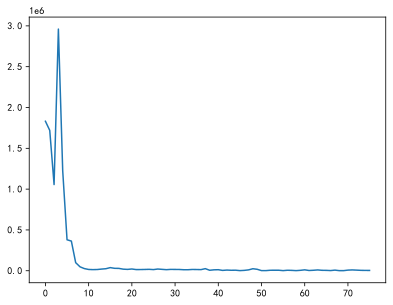

In [12]:
plt.plot(cov(a.critic_mse, lambda x:sum(x)/len(x), 100, 100))

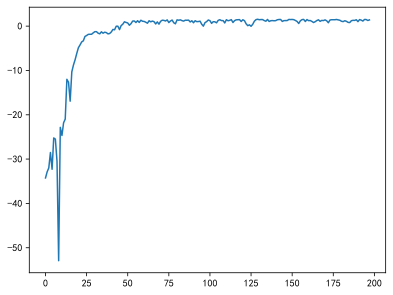

In [13]:
plt.plot(cov(a.his, lambda x:sum(x)/len(x), 10000, 10000))

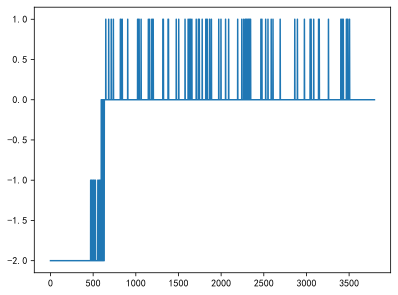

In [14]:
plt.plot(a.final_reward)

列表的均值: 88.29163695799058
展平后的列表最大值: 99.81482910575123
展平后的列表数目: 22305


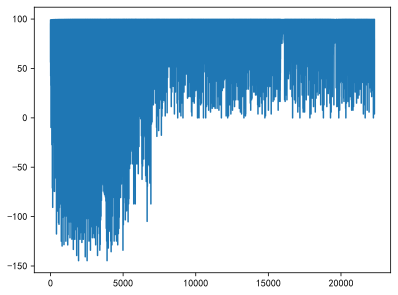

In [ ]:
plt.plot(a.train_data.dis_reward)
arr=a.train_data.dis_reward
arr = [item for sublist in arr for item in sublist]
# 确保 `arr` 是数值的平坦列表
if all(isinstance(i, (int, float)) for i in arr):
    mean_value = sum(arr) / len(arr)
    print(f"列表的均值: {mean_value}")
else:
    print("列表中包含非数值元素或嵌套列表，无法计算均值。")
max_value = max(arr)
num_value=len(arr)
print(f"展平后的列表最大值: {max_value}")
print(f"展平后的列表数目: {num_value}")

In [ ]:
arr=a.final_reward[5000:]
count_ones = arr.count(1)

# 计算总元素数量
total_elements = len(arr)

# 计算值为1的元素占比
percentage_ones = count_ones / total_elements

print(f"值为1的元素占比: {percentage_ones:.2%}")

ZeroDivisionError: division by zero

In [ ]:
def record_his(a: Agent, file_path):
    with open(file_path, 'w') as f:
        f.write(str({
            'his':a.his,
            'mse':a.critic_mse,
            'rew':a.final_reward,
        }))

def load_his(a: Agent, file_path):
    with open(file_path, 'r') as f:
        data = eval(f.read())
        a.his = data['his']
        a.critic_mse = data['mse']
        a.final_reward = data['rew']

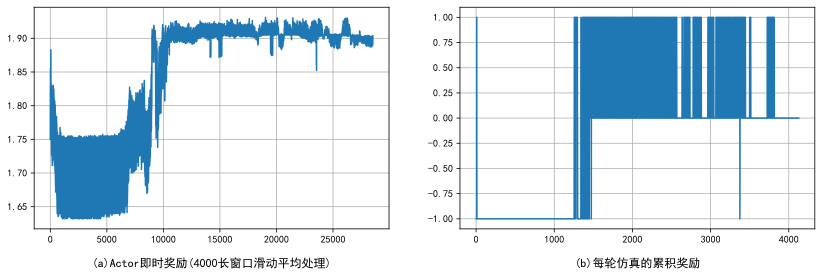

In [ ]:
plt.rcParams['figure.figsize'] = (14,4)
rate = 0.05

plt.subplot(1, 2, 1)
plt.title('(a)Actor即时奖励(4000长窗口滑动平均处理)', y=-0.2)
plt.plot(cov(a.his, lambda x:sum(x)/len(x), 4000, 200))
plt.grid()
plt.subplot(1, 2, 2)
plt.title('(b)每轮仿真的累积奖励', y=-0.2)
mean_plot(a.final_reward, 1, 1)
plt.grid()